#### benchmark case GO

In [6]:
import pandas as pd
import numpy as np
data = pd.read_pickle("../datasets_embedding/onehot/benchmark_meqtl_dataset/slope_prediction/mono/small_test.dataset")[0:501]
data.head()

,CpG,SNP,Beta,Ref,Alt,CHR,CpG_POS,SNP_POS,seq_before,seq_after,seq_len
0,cg18498427,10:98236314_T_C,5.287748,T,C,chr10,98244693,98236314,cacatggccttctctgtctgtcctcttcttttcctataagcatgtc...,cacatggccttctctgtctgtcctcttcttttcctataagcatgtc...,20001
1,cg23345711,10:91927575_A_G,7.740159,A,G,chr10,91928364,91927575,atggtgatgtacagatgggtttttggtgtggatgtcctttctgttt...,atggtgatgtacagatgggtttttggtgtggatgtcctttctgttt...,20001
2,cg20867662,10:35057266_A_G,5.059728,A,G,chr10,35058987,35057266,AGCCAACTATATTATGTAAGTAATCTCAAtgtgggaggcagcctct...,AGCCAACTATATTATGTAAGTAATCTCAAtgtgggaggcagcctct...,20001
3,cg12653707,10:38083510_G_A,21.933512,G,A,chr10,38073886,38083510,actgggtctcaccatgtggccaagctggtctcaaactcttgatctc...,actgggtctcaccatgtggccaagctggtctcaaactcttgatctc...,20001
4,cg25862470,10:99149012_G_A,5.737860,G,A,chr10,99148114,99149012,attgctcctaggctacaaacctggacagcatgttgctgtactgagt...,attgctcctaggctacaaacctggacagcatgttgctgtactgagt...,20001


In [8]:
data['pred'] = 0
y_pred = np.load('../datasets/case_datasets/small-outputs-mono(slope_prediction)_2.npy')
for i in range(len(data)):
    data['pred'][i] = y_pred[i]
new_data = data[['CpG','SNP','CHR','CpG_POS','pred']]
new_data.head()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_35732\617109769.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['pred'][i] = y_pred[i]


,CpG,SNP,CHR,CpG_POS,pred
0,cg18498427,10:98236314_T_C,chr10,98244693,-8.041308
1,cg23345711,10:91927575_A_G,chr10,91928364,15.693016
2,cg20867662,10:35057266_A_G,chr10,35058987,-10.377987
3,cg12653707,10:38083510_G_A,chr10,38073886,5.091702
4,cg25862470,10:99149012_G_A,chr10,99148114,-6.054877


In [9]:
import requests
import gzip
import io
import pandas as pd

# Download the hg19 gene annotation file (GTF format) from UCSC
url = "http://hgdownload.soe.ucsc.edu/goldenPath/hg19/bigZips/genes/hg19.refGene.gtf.gz"
response = requests.get(url)

# Decompress the file and read it into a pandas DataFrame
with gzip.open(io.BytesIO(response.content), 'rt') as f:
    # Since GTF has a specific format, we'll parse it
    gene_annotations = pd.read_csv(f, sep="\t", comment="#", header=None, 
                                   names=["chrom", "source", "feature", "start", "end", "score", "strand", "frame", "attribute"])

# Filter for TSS locations (considering the start of genes)
tss_annotations = gene_annotations[gene_annotations['feature'] == 'transcript'].copy()

# Extract gene name and TSS
tss_annotations['gene_name'] = tss_annotations['attribute'].str.extract(r'gene_name "([^"]+)"')

# Calculate TSS based on strand information
tss_annotations['tss'] = tss_annotations.apply(lambda row: row['start'] if row['strand'] == '+' else row['end'], axis=1)

# Simplify the data to necessary columns: chrom, tss, gene_name
tss_annotations = tss_annotations[['chrom', 'tss', 'gene_name']]

# Display the first few rows of the TSS annotation data
print(tss_annotations.head())

    chrom       tss     gene_name
0    chr1     11869  LOC102725121
4    chr1     11874       DDX11L1
8   chr22  24666799       SPECC1L
47   chr1     17436     MIR6859-1
49   chr1     17436     MIR6859-2


In [14]:
# Task 1: Filter rows where 'pred' column absolute value is greater than 0.2
filtered_data = new_data[new_data['pred'].abs() > 0.2].reset_index(drop=True)

# Function to get TSS and gene names within 2kb upstream and downstream of the CpG position
def get_nearby_tss(chr, pos, tss_annotations):
    # Filter the TSS annotations based on chromosome and position range (2kb upstream/downstream)
    nearby_tss = tss_annotations[(tss_annotations['chrom'] == chr) & 
                                 (tss_annotations['tss'] >= pos - 20000) & 
                                 (tss_annotations['tss'] <= pos + 20000)]
    
    # Create a string of gene names and their TSS positions
    tss_info = [f"{row['gene_name']}({row['tss']})" for _, row in nearby_tss.iterrows()]
    return "; ".join(tss_info)

# Task 2: Annotate filtered data with TSS and gene names
filtered_data['TSS_Genes'] = filtered_data.apply(
    lambda row: get_nearby_tss(row['CHR'], row['CpG_POS'], tss_annotations), axis=1)

# Save the result to a new CSV
#filtered_data.to_csv('annotated_data.csv', index=False)
filtered_data.head()

,CpG,SNP,CHR,CpG_POS,pred,TSS_Genes
0,cg18498427,10:98236314_T_C,chr10,98244693,-8.041308,
1,cg23345711,10:91927575_A_G,chr10,91928364,15.693016,
2,cg20867662,10:35057266_A_G,chr10,35058987,-10.377987,
3,cg12653707,10:38083510_G_A,chr10,38073886,5.091702,ZNF33BP1(38084103)
4,cg25862470,10:99149012_G_A,chr10,99148114,-6.054877,RRP12(99161097); RRP12(99161097); RRP12(99161127)


In [15]:
gene_list = []

for genes in filtered_data['TSS_Genes']:
    if pd.notnull(genes):  # Check if the value is not NaN
        # Split the concatenated string by '; ' and extract the gene names (remove TSS positions)
        gene_list.extend([gene.split('(')[0] for gene in genes.split('; ')])

# Remove duplicates and sort the list
unique_genes = sorted(set(gene_list))

# Print the list or save to a file
print(unique_genes)

# Optionally, save to a text file
with open('gene_list.txt', 'w') as f:
    f.write('\n'.join(unique_genes))

['', 'ACY3', 'AMPD3', 'APOA1', 'APOA1-AS', 'APOA4', 'APOC3', 'ARMC3', 'ARMS2', 'B3GAT3', 'BRSK2', 'C10orf55', 'C10orf82', 'CALHM1', 'CALHM2', 'CASP12', 'CCKBR', 'CDH23', 'CDHR5', 'CDKN1C', 'CHAT', 'CHORDC1', 'COMTD1', 'DAGLA', 'DBX1', 'DCLRE1CP1', 'DDI1', 'DDIT4', 'DEPP1', 'DPYSL4', 'EML3', 'FAM99A', 'FGF3', 'FGF8', 'FLJ42102', 'FRMD8', 'GATA3', 'GATA3-AS1', 'GFRA1', 'GUCY2EP', 'GUCY2GP', 'HIPK3', 'HRAS', 'HTRA1', 'IFITM1', 'IFITM2', 'IFITM3', 'IFITM5', 'IRF7', 'KCNE3', 'KCNQ1-AS1', 'KCNQ1DN', 'KRTAP5-4', 'KRTAP5-5', 'LBX1', 'LBX1-AS1', 'LINC02688', 'LINC02870', 'LMNTD2', 'LMNTD2-AS1', 'LOC100132078', 'LOC101929340', 'LOC102724265', 'LOC102724323', 'LOC105376360', 'LOC143666', 'LRP5', 'LRRC56', 'LSP1', 'MICAL2', 'MIR210', 'MIR210HG', 'MIR4298', 'MIR4697HG', 'MIR5579', 'MIR6744', 'MIR6754', 'MIR7152', 'MIR7154', 'MIR7847', 'MMP3', 'MRGPRE', 'MRGPRG', 'MRGPRG-AS1', 'MTA2', 'MUC2', 'MYRF', 'MYRF-AS1', 'NCAM1-AS1', 'NEAT1', 'NLRP6', 'NNMT', 'NPM3', 'NRGN', 'NUDT8', 'OLAH', 'OPALIN', 'OPCML

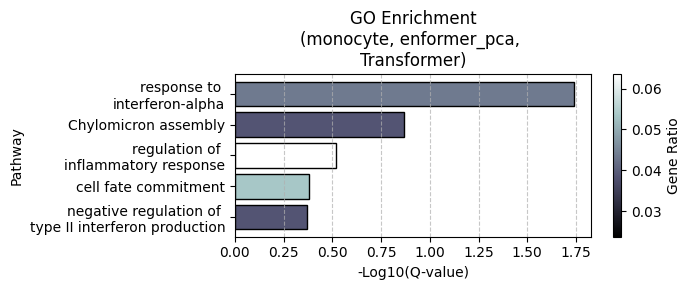

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

data_all = {
    'Pathway': [
        'response to \ninterferon-alpha',
        'Chylomicron assembly',
        'regulation of \ninflammatory response',
        'cell fate commitment',
        'negative regulation of \ntype II interferon production'
    ],
    'Gene Ratio': [0.0317, 0.0238, 0.0635, 0.0476, 0.0238],
    'Count': [4, 3, 8, 6, 3],
    'Q-value': [-1.74, -0.87, -0.52, -0.38, -0.37]  # Log10(q)
}

df = pd.DataFrame(data_all)

# Create a horizontal bar plot with -log10(Q-value) as the x-axis and Gene Ratio as the color
plt.figure(figsize=(7, 3))

# Sort the data for better visual arrangement
df_sorted = df.sort_values('Q-value', ascending=False)

# Create the bar plot
bars = plt.barh(
    df_sorted['Pathway'],
    -df_sorted['Q-value'],  # Use -log10(Q-value) for the x-axis
    color=plt.cm.bone(df_sorted['Gene Ratio'] / max(df_sorted['Gene Ratio'])),  # Color by Gene Ratio
    edgecolor='black'
)

# Add a color bar to represent Gene Ratio
sm = plt.cm.ScalarMappable(cmap='bone', norm=plt.Normalize(vmin=min(df_sorted['Gene Ratio']), vmax=max(df_sorted['Gene Ratio'])))
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Gene Ratio')

# Add labels and title
plt.xlabel('-Log10(Q-value)')
plt.ylabel('Pathway')
plt.title('GO Enrichment\n(monocyte, enformer_pca, \nTransformer)')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.savefig('images/case/GO-plot.png',dpi=300, bbox_inches = 'tight')
plt.show()